# Computer Vision (Image operators and filters)

By the end of this lab, you will get hands on experience working with:

*   Image Handling
*   Image Manipulation
*   Histogram and Histogram Equalization
*   Basic filtering techniques

<!-- ### **Remember this is a graded exercise.** -->

**Reminder**:

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Add sufficient comments and explanations wherever necessary.

---


In [30]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from matplotlib import pyplot as plt
from skimage import data, exposure, filters, color
from skimage.filters import rank
from skimage.morphology import disk, footprint_rectangle, diamond, star

# Channels and color spaces

### **Exercise: Image Creation and Color Manipulation**

*   Create a 100 x 100 image for each of the below visualization

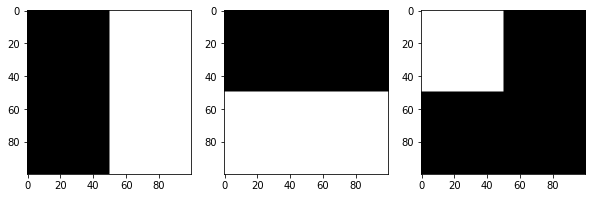

*   Visualize the created images in a 1 x 3 subplot using matplotlib.


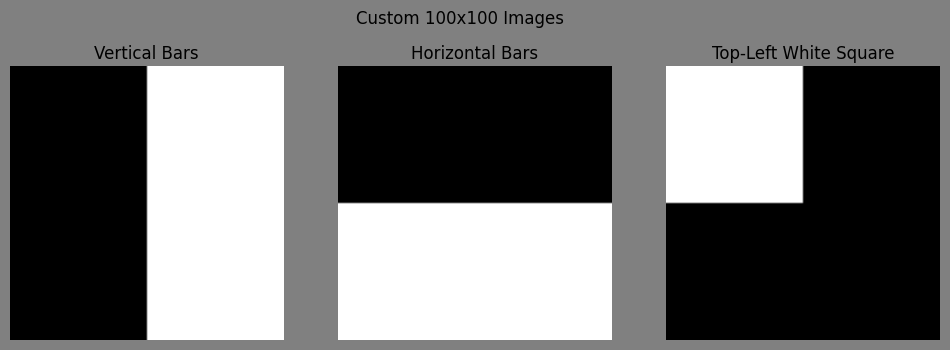

In [31]:
# --- 1) Create 100x100 images ---

# First: vertical split (left black, right white)
img_vertical = np.zeros((100, 100), dtype=np.uint8)
img_vertical[:, 50:] = 255  # right half white

# Second: horizontal split (top black, bottom white)
img_horizontal = np.zeros((100, 100), dtype=np.uint8)
img_horizontal[50:, :] = 255  # bottom half white

# Third: all black except top-left square white
img_corner = np.zeros((100, 100), dtype=np.uint8)
img_corner[0:50, 0:50] = 255  # top-left quadrant white

# --- 2) Plot images ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4), facecolor='gray')

axes[0].imshow(img_vertical, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Vertical Bars")
axes[0].axis("off")

axes[1].imshow(img_horizontal, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Horizontal Bars")
axes[1].axis("off")

axes[2].imshow(img_corner, cmap='gray', vmin=0, vmax=255)
axes[2].set_title("Top-Left White Square")
axes[2].axis("off")

plt.suptitle("Custom 100x100 Images")
plt.show()

*   Use the above three images to create the following image

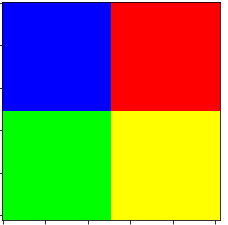
*Hint: Remember channels and color spaces*

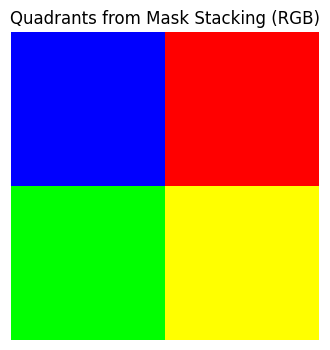

In [32]:
# Recreate the quadrant color image using the earlier 3 grayscale masks as channels

# Ensure we have the original 3 masks again
img_vertical = np.zeros((100, 100), dtype=np.uint8)
img_vertical[:, 50:] = 255  # right half white

img_horizontal = np.zeros((100, 100), dtype=np.uint8)
img_horizontal[50:, :] = 255  # bottom half white

img_corner = np.zeros((100, 100), dtype=np.uint8)
img_corner[0:50, 0:50] = 255  # top-left white square

# Stack into channels: BGR or RGB? We want final image with TL=Blue, TR=Red, BL=Green, BR=Yellow
# Let's assign: Blue channel = img_corner, Red channel = img_vertical, Green channel = img_horizontal

blue_channel = img_corner
red_channel = img_vertical
green_channel = img_horizontal

# Stack into RGB image
img_quadrants_from_masks = np.dstack([red_channel, green_channel, blue_channel])

# Display
plt.figure(figsize=(4,4))
plt.imshow(img_quadrants_from_masks)
plt.title("Quadrants from Mask Stacking (RGB)")
plt.axis("off")
plt.show()

### **Exercise: Color Manipulation**

*   Read the image 'sillas.jpg' from the images folder

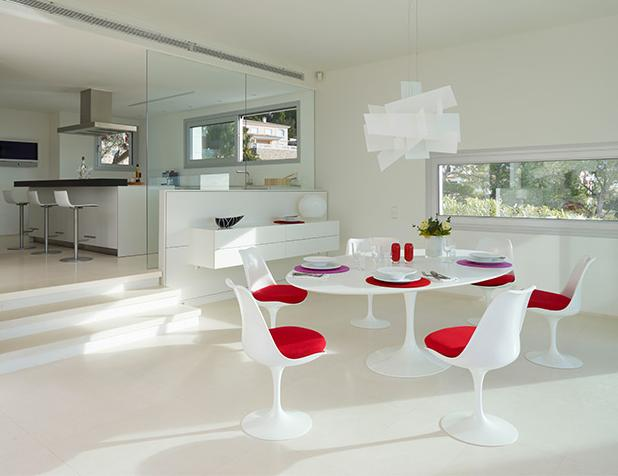

*   Extract individual channels and plot them using matplotlib subplot.



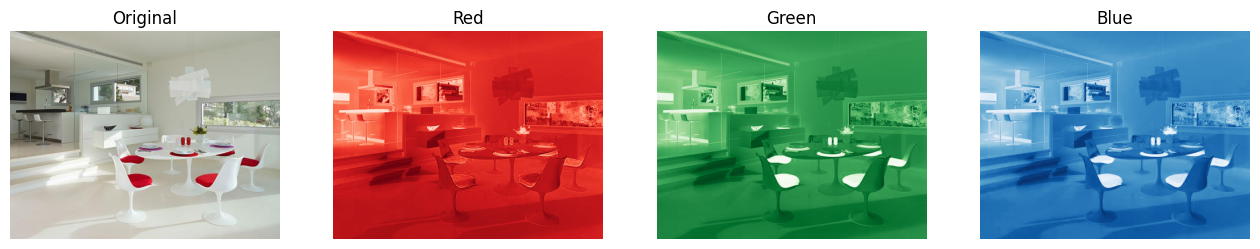

In [33]:
from skimage import io
import matplotlib.pyplot as plt

# Load (already RGB)
img = io.imread("images/sillas.jpg")

R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]

fig, axes = plt.subplots(1,4, figsize=(16,4))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(R, cmap="Reds")
axes[1].set_title("Red")
axes[1].axis("off")

axes[2].imshow(G, cmap="Greens")
axes[2].set_title("Green")
axes[2].axis("off")

axes[3].imshow(B, cmap="Blues")
axes[3].set_title("Blue")
axes[3].axis("off")

plt.show()

*   The color **red** looks too bright for the eyes. Isn't it?? Lets change the color and see how it appears.
    *    Create a new image where everything that is **'red' is changed to 'blue'**.
*   Visualize the original image and the created image using matplotlib subplot.

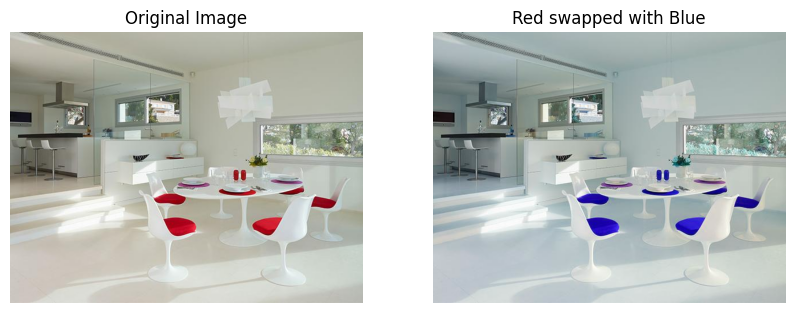

In [34]:
# Copy to avoid changing original
img_swapped = img.copy()

# Swap red and blue channels
img_swapped[:,:,0] = img[:,:,2]   # new Red   <- old Blue
img_swapped[:,:,2] = img[:,:,0]   # new Blue  <- old Red

# Plot original and modified
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(img_swapped)
axes[1].set_title("Red swapped with Blue")
axes[1].axis("off")

plt.show()

# Image Manipulation

### **Exercise: Image Operators**

*   You can find images 'model.png' and 'coat.png' in the images folder (First two images of the below visualization). Your task is to create an image from the given two images such a way that the model is wearing the coat (Third image in the visualization).
*   You can also find different textures in the images folder. Your task is to change the coat texture to any one of the given textures.
*   Visualize the images similar to the given visualization.

*Hint: Think masks!!!*

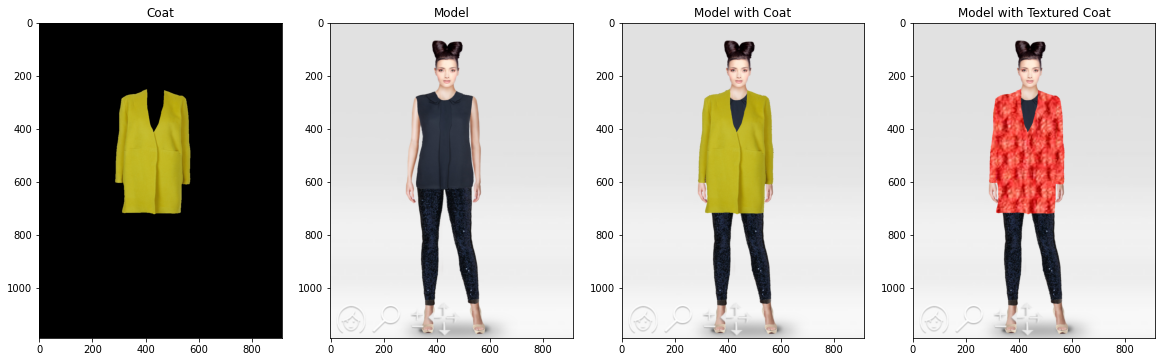

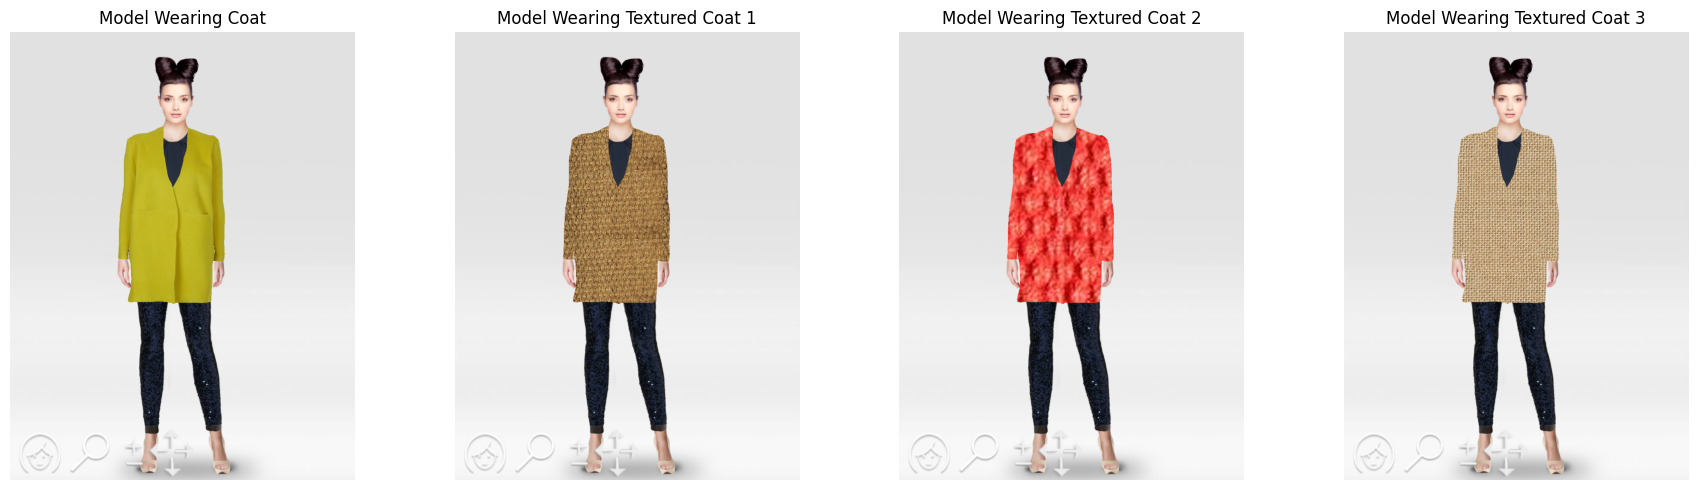

In [35]:
# 1) Read as float32 in [0,1] and force RGB (drop alpha if present)
model = io.imread("images/model.png")[..., :3].astype(np.float32) / 255.0
coat  = io.imread("images/coat.png")[..., :3].astype(np.float32) / 255.0
tex   = io.imread("images/texture.png")[..., :3].astype(np.float32) / 255.0
tex2  = io.imread("images/texture2.png")[..., :3].astype(np.float32) / 255.0
tex3  = io.imread("images/texture3.jpg")[..., :3].astype(np.float32) / 255.0

# 2) Binary coat mask via Otsu on simple grayscale
gray = coat.mean(axis=2)
th = filters.threshold_otsu(gray)
mask = gray > th

# 3) Paste coat at top-left (0,0)
h, w = coat.shape[:2]
composite = model.copy()
# why: np.where is concise and avoids boolean indexing side-effects
composite[:h, :w] = np.where(mask[..., None], coat[:h, :w], composite[:h, :w])

# 4) Retexture: tile to (h, w)
textures = [tex, tex2, tex3]

composites_tex = []

for t in textures:
    th_tex, tw_tex = t.shape[:2]
    # Tile texture up to (h, w)
    tex_tiled = np.tile(t, (h // th_tex + 1, w // tw_tex + 1, 1))[:h, :w]

    # Paste texture where mask is True
    comp = model.copy()
    comp[:h, :w] = np.where(mask[..., None], tex_tiled, comp[:h, :w])

    composites_tex.append(comp)

# 5) Show results (Model | Coat | Model+Coat | Model+TexturedCoat)
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes[0].imshow(composite); axes[0].set_title("Model Wearing Coat"); axes[0].axis("off")
axes[1].imshow(composites_tex[0]); axes[1].set_title("Model Wearing Textured Coat 1"); axes[1].axis("off")
axes[2].imshow(composites_tex[1]); axes[2].set_title("Model Wearing Textured Coat 2"); axes[2].axis("off")
axes[3].imshow(composites_tex[2]); axes[3].set_title("Model Wearing Textured Coat 3"); axes[3].axis("off")
plt.tight_layout()
plt.show()

# Contrast Enhancement

### **Exercise: Histogram Computation**

*   Read the **'astronaut' image** from data module.
*   Convert the image to grayscale.
*   Compute the **histogram of the image.** *Hint: histogram function is available in skimage.exposure package*
*   Plot the histogram using matplotlib plot.




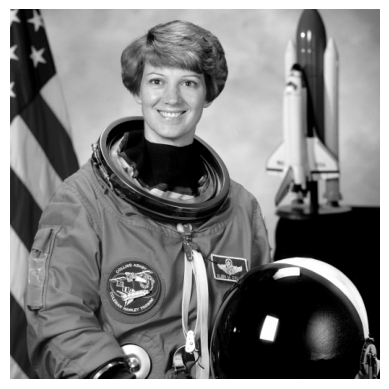

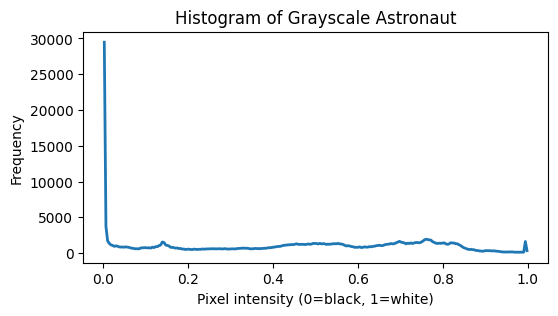

In [36]:
# Load the astronaut image
image = data.astronaut()

# Convert to grayscale
gray_image = color.rgb2gray(image)

# Display the grayscale image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

# Compute histogram (256 bins between 0 and 1)
hist, bin_centers = exposure.histogram(gray_image, nbins=256)

# Plot histogram
plt.figure(figsize=(6,3))
plt.plot(bin_centers, hist, lw=2)
plt.title("Histogram of Grayscale Astronaut")
plt.xlabel("Pixel intensity (0=black, 1=white)")
plt.ylabel("Frequency")
plt.show()

*   Change the bin count to 8 and compute the histogram of the image and plot the computed histogram using matplotlib plot.

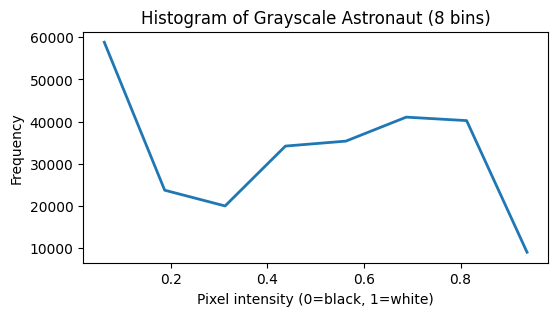

In [37]:
# Compute histogram with 8 bins
hist8, bin_centers8 = exposure.histogram(gray_image, nbins=8)

# Plot histogram
plt.figure(figsize=(6,3))
plt.plot(bin_centers8, hist8, lw=2)
plt.title("Histogram of Grayscale Astronaut (8 bins)")
plt.xlabel("Pixel intensity (0=black, 1=white)")
plt.ylabel("Frequency")
plt.show()



*   What happens when you change the bin count? Does your inference change based on the bin count? If yes, then how do you define the correct bin count.
*   What happens when the bin count is very low and what happens when it is very high?



**Solution**

When the bin count is low, the histogram becomes coarse: fine intensity variations are lost and only broad brightness trends are visible. When the bin count is high, the histogram shows much more detail but can look noisy and harder to interpret visually.

The “correct” bin count depends on purpose: for human readability, fewer bins may suffice; for image processing tasks like contrast adjustment, a higher bin count (e.g., 256 for 8-bit images) is preferred to capture intensity variations accurately.


*   Compute histogram of the color image (without converting it to grayscale).
*   Plot the total histogram and also histogram for each channel (show it in a single plot with differnt legends for each histogram).


c:\Users\leonb\Ironhack\.venv\Lib\site-packages\skimage\_shared\utils.py:445: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


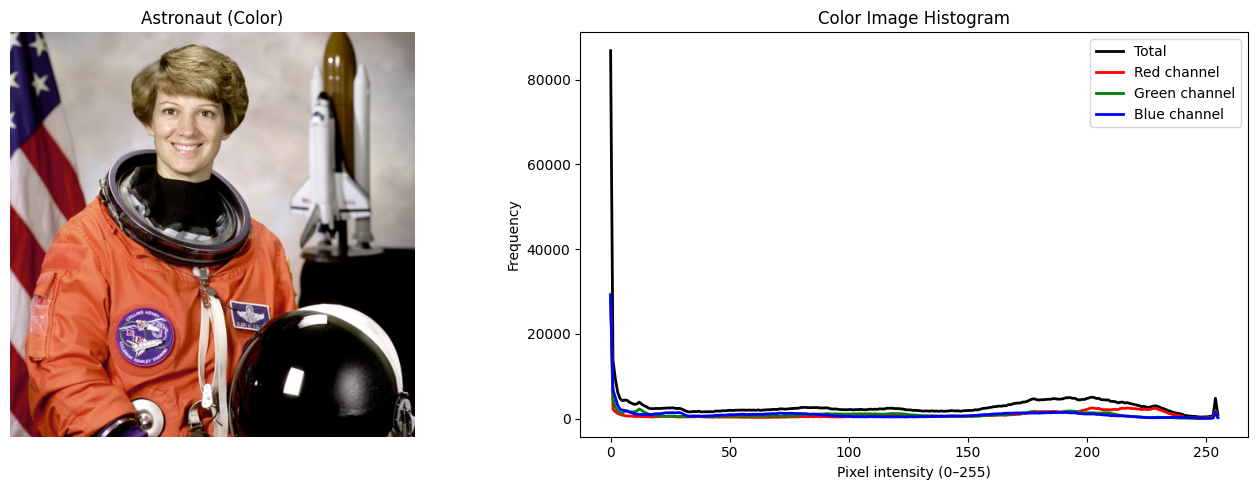

In [38]:
# Histogram for all channels
hist_total, bin_centers = exposure.histogram(image, nbins=256)

# Histograms per channel
colors = ('red', 'green', 'blue')
channel_hists = []
for i, col in enumerate(colors):
    hist, bins = exposure.histogram(image[..., i], nbins=256)
    channel_hists.append((hist, bins, col))

# Plot: image on the left, histogram on the right
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Show the reference image
axes[0].imshow(image)
axes[0].set_title("Astronaut (Color)")
axes[0].axis("off")

# Show the histograms
axes[1].plot(bin_centers, hist_total, color='black', label='Total', lw=2)
for hist, bins, col in channel_hists:
    axes[1].plot(bins, hist, color=col, label=f'{col.capitalize()} channel', lw=2)

axes[1].set_title("Color Image Histogram")
axes[1].set_xlabel("Pixel intensity (0–255)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

### **Exercise: Histogram Equalization**

*   Read 'aquatermi_lowcontrast.jpg' image from the images folder.
*   Compute the histogram of the image.
*   Perform histogram equalization of the image to enhance the contrast. *Hint: Use equalize_hist function available in skimage.exposure*
*   Also compute histogram of the equalized image.
*   Use 2 x 2 subplot to show the original image and the enhanced image along with the corresponding histograms.



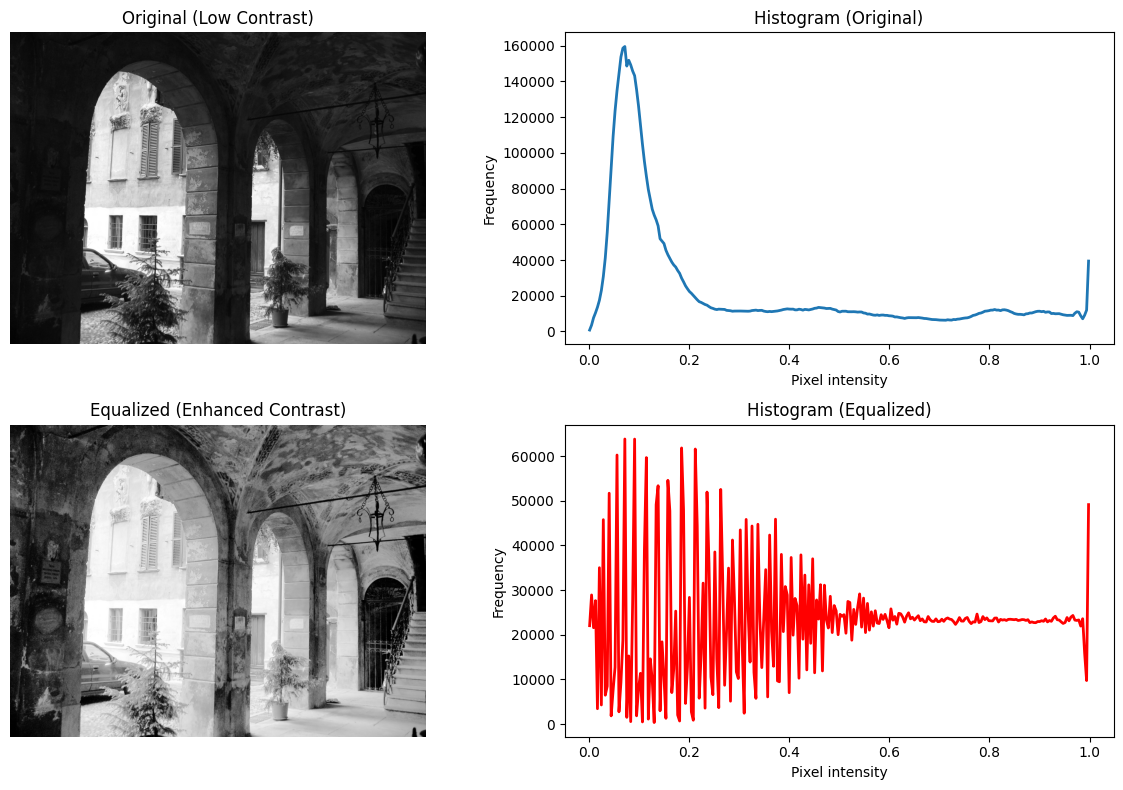

In [39]:
# 1. Load the low-contrast image
img = io.imread("images/aquatermi_lowcontrast.jpg")

# 2. Convert to grayscale (histogram equalization is usually done on single-channel images)
gray = color.rgb2gray(img)

# 3. Compute histogram of the original grayscale
hist_orig, bins_orig = exposure.histogram(gray, nbins=256)

# 4. Perform histogram equalization
equalized = exposure.equalize_hist(gray)

# 5. Compute histogram of the equalized image
hist_eq, bins_eq = exposure.histogram(equalized, nbins=256)

# 6. Plot everything in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original grayscale image
axes[0,0].imshow(gray, cmap='gray')
axes[0,0].set_title("Original (Low Contrast)")
axes[0,0].axis("off")

# Histogram of original
axes[0,1].plot(bins_orig, hist_orig, lw=2)
axes[0,1].set_title("Histogram (Original)")
axes[0,1].set_xlabel("Pixel intensity")
axes[0,1].set_ylabel("Frequency")

# Equalized image
axes[1,0].imshow(equalized, cmap='gray')
axes[1,0].set_title("Equalized (Enhanced Contrast)")
axes[1,0].axis("off")

# Histogram of equalized
axes[1,1].plot(bins_eq, hist_eq, lw=2, color='red')
axes[1,1].set_title("Histogram (Equalized)")
axes[1,1].set_xlabel("Pixel intensity")
axes[1,1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


*   The above function in skimage.exposure uses cdf and interpolation technique to normalize the histogram. How is it different from linear contrast stretch?


**Solution**

- Histogram equalization is adaptive to the distribution of pixel values (non-linear mapping).
- Linear contrast stretch is a uniform scaling of the range (linear mapping).

### **Exercise: Linear Contrast Stretch**

*   Write a function to compute the linear contrast stretch (Do not use an inbuilt function). 
*   Provide grayscale image array and bin count as parameters to the function and return the enhanced image array.
*   Use a 2 x 2 plot to visualize the original image, histogram, enhanced image and the corresponding histogram.



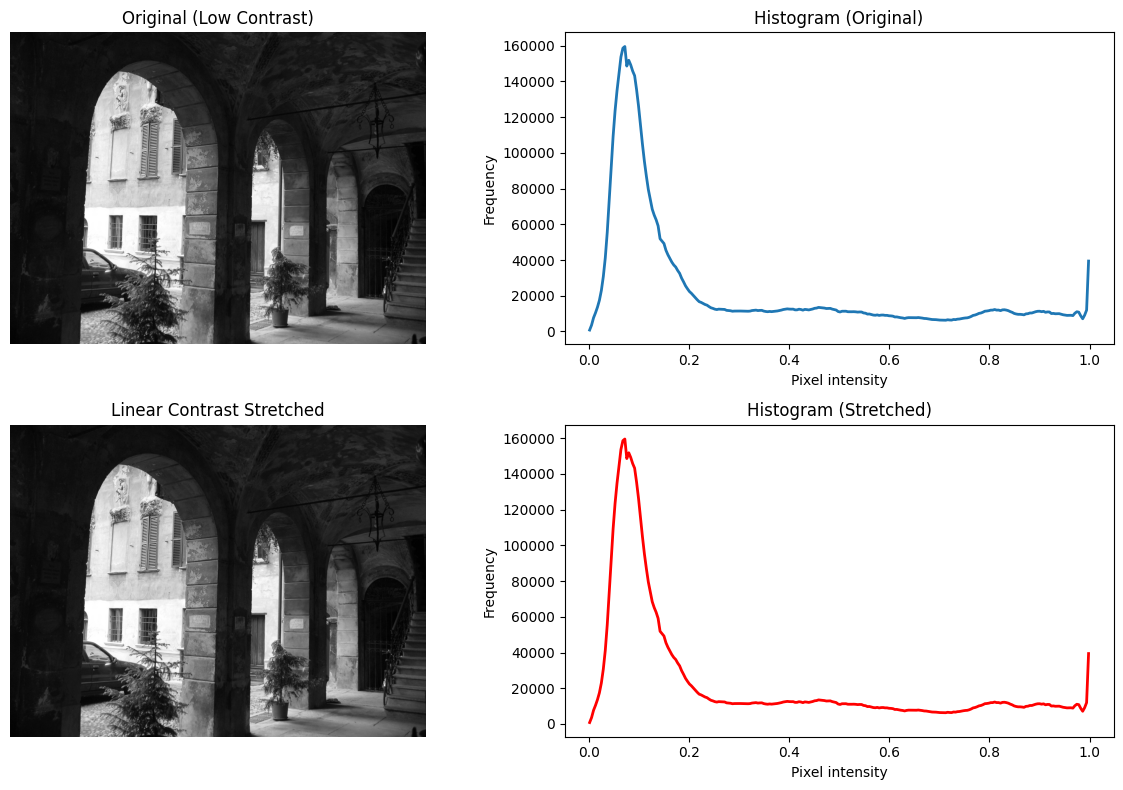

In [40]:
# --- Function for linear contrast stretch ---
def linear_contrast_stretch(img_gray, nbins=256):
    """
    Apply linear contrast stretch to a grayscale image.
    
    Parameters:
        img_gray : ndarray
            Grayscale image (values in [0,1] or [0,255]).
        nbins : int
            Number of bins for histogram computation.
            
    Returns:
        stretched : ndarray
            Contrast-stretched grayscale image (in [0,1]).
        hist, bins : ndarray
            Histogram and bin centers of the stretched image.
    """
    # Ensure float
    img = img_gray.astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0  # normalize if 0-255
    
    Imin, Imax = img.min(), img.max()
    # Avoid divide by zero
    stretched = (img - Imin) / (Imax - Imin + 1e-8)
    
    # Histogram of enhanced image
    hist, bins = exposure.histogram(stretched, nbins=nbins)
    return stretched, hist, bins

# --- Example: Use aquatermi_lowcontrast.jpg ---
img = io.imread("images/aquatermi_lowcontrast.jpg")
gray = color.rgb2gray(img)

# Histogram of original
hist_orig, bins_orig = exposure.histogram(gray, nbins=256)

# Apply linear contrast stretch
stretched, hist_stretched, bins_stretched = linear_contrast_stretch(gray, nbins=256)

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# Original grayscale
axes[0,0].imshow(gray, cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title("Original (Low Contrast)")
axes[0,0].axis("off")

# Original histogram
axes[0,1].plot(bins_orig, hist_orig, lw=2)
axes[0,1].set_title("Histogram (Original)")
axes[0,1].set_xlabel("Pixel intensity")
axes[0,1].set_ylabel("Frequency")

# Enhanced grayscale
axes[1,0].imshow(stretched, cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title("Linear Contrast Stretched")
axes[1,0].axis("off")

# Enhanced histogram
axes[1,1].plot(bins_stretched, hist_stretched, lw=2, color='red')
axes[1,1].set_title("Histogram (Stretched)")
axes[1,1].set_xlabel("Pixel intensity")
axes[1,1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Filters

### **Exercise: Mean Filter**

*   Load the **coins** image from the data module.
*   Define a disk structuring element (selem) of radius 20. *Hint: Structuring elements are defined in the skimage.morphology module*
*   Use mean filter using the created selem. *Hint: The mean filter is available in skimage.filters.rank module*
*   Increase the radius of the selem by 10 and apply the mean filter.
*   Reduce the radius of the selem by 10 and apply the mean filter.
*   Visualize all the smoothened images along with the original image.




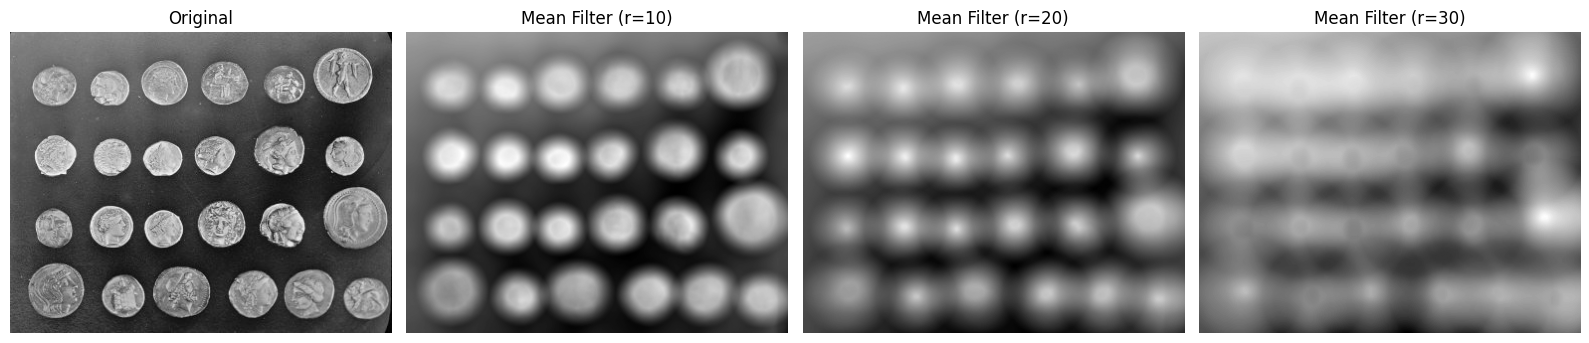

In [41]:
# 1. Load coins image (grayscale)
image = data.coins()

# 2. Define structuring elements (disk-shaped) with different radii
selem_small = disk(10)   # radius -10
selem_base  = disk(20)   # radius 20
selem_large = disk(30)   # radius +10

# 3. Apply mean filter with each selem
mean_small = rank.mean(image, footprint=selem_small)
mean_base  = rank.mean(image, footprint=selem_base)
mean_large = rank.mean(image, footprint=selem_large)

# 4. Plot all results
fig, axes = plt.subplots(1, 4, figsize=(16,5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(mean_small, cmap='gray')
axes[1].set_title("Mean Filter (r=10)")
axes[1].axis("off")

axes[2].imshow(mean_base, cmap='gray')
axes[2].set_title("Mean Filter (r=20)")
axes[2].axis("off")

axes[3].imshow(mean_large, cmap='gray')
axes[3].set_title("Mean Filter (r=30)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

*   Use different selem (square, rectangle, star, diamond) to view the behaviour of the mean filter (It is not necessary to repeat with different sizes; it is sufficient to show the one with optimal parameter).
*   Create a 2 x n subplot to show the selem in the first row and the corresponding smoothened image in the second row.

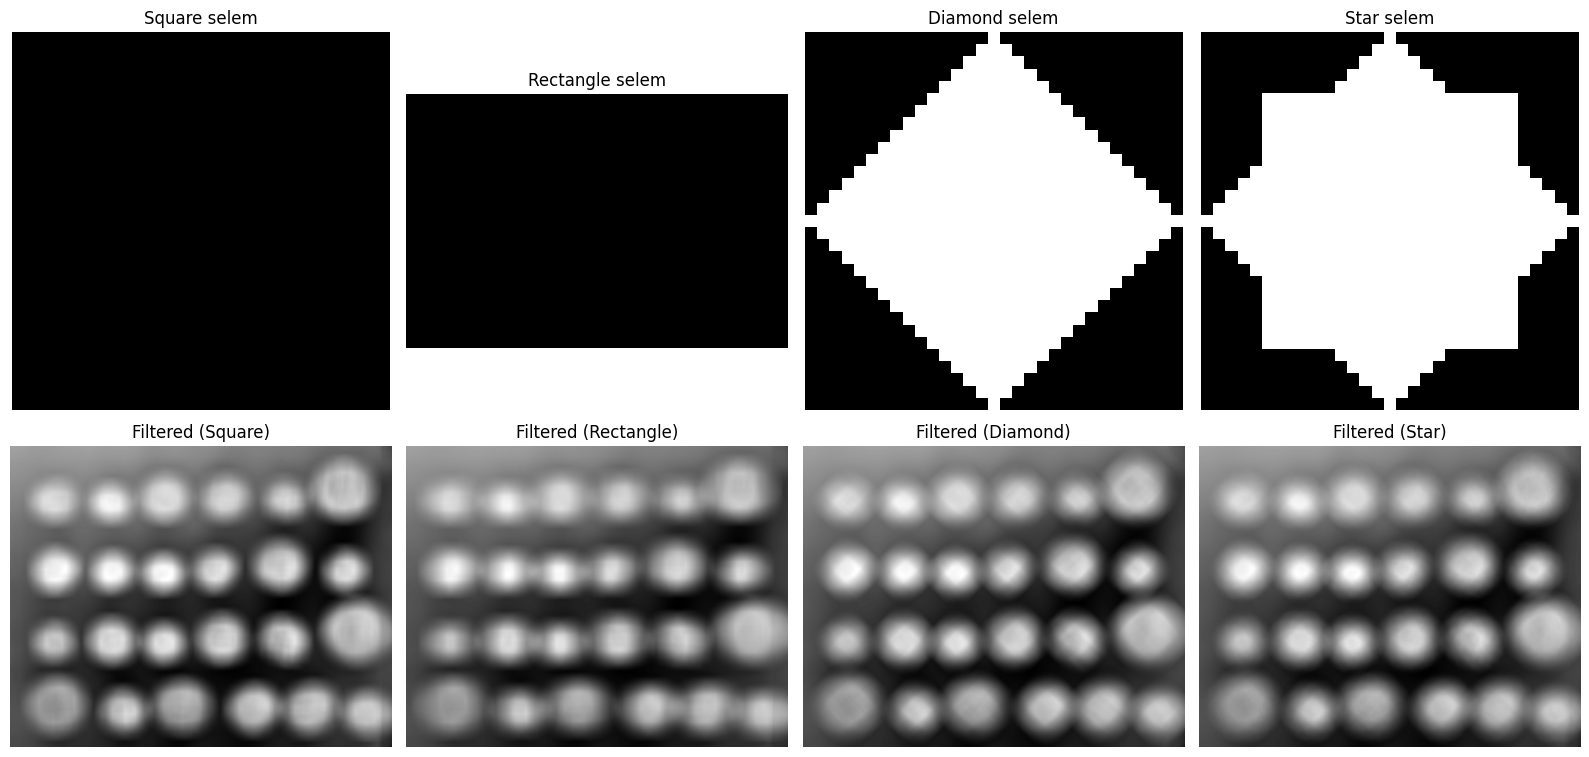

In [42]:
# Define different structuring elements
selems = {
    "Square": footprint_rectangle((20, 20)),
    "Rectangle": footprint_rectangle((20, 30)),
    "Diamond": diamond(15),
    "Star": star(10)
}

# Apply mean filter with each structuring element
results = {}
for name, selem in selems.items():
    results[name] = rank.mean(image, footprint=selem)

# Create subplot: first row = SELEM shape, second row = filtered image
fig, axes = plt.subplots(2, len(selems), figsize=(4*len(selems), 8))

for i, (name, selem) in enumerate(selems.items()):
    # Show structuring element (as image)
    axes[0, i].imshow(selem, cmap='gray')
    axes[0, i].set_title(f"{name} selem")
    axes[0, i].axis("off")
    
    # Show filtered image
    axes[1, i].imshow(results[name], cmap='gray')
    axes[1, i].set_title(f"Filtered ({name})")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

*   How does changing the radius of disk affect the smoothing functionality?

**Solution**

- A small radius → only nearby pixels are averaged → light smoothing, details and edges are mostly preserved.
- A large radius → a much bigger neighborhood is averaged → strong smoothing, fine details and textures get blurred away, and the image looks more uniform.


*   What is the observed behaviour with difference in the structuring element?



**Solution**

- With a square/rectangle, smoothing tends to be uniform in horizontal and vertical directions.
- With a disk/diamond, the smoothing is more isotropic (circular), giving a softer, rounded blur.
- With a star, the averaging emphasizes pixels along diagonals and crosses, so the smoothing has a slightly directional character.



*   What is the difference between mean filter and gaussian filter?
*   Where do you use mean filters and where do you use gaussian filters?



**Solution**

### Difference:
- Mean filter (box filter): replaces each pixel with the average of its neighborhood. All pixels in the window are given equal weight. This leads to smoothing but also tends to blur edges strongly and can introduce blocky artifacts.

- Gaussian filter: replaces each pixel with a weighted average of its neighborhood, where weights follow a Gaussian curve (closer pixels contribute more). This produces smoother, more natural blurring and preserves edges better than the mean filter.


### When to use:
**Mean filter:**
- Simple, fast, and easy to implement.
- Useful for reducing random noise (like salt-and-pepper noise).
- Often used as a preprocessing step where speed matters more than fine detail.

**Gaussian filter:**
- Preferred when you need smoother, visually pleasing blur.
- Common in edge detection (e.g., Canny uses Gaussian) because it reduces noise while preserving edge structure.
- Used in many vision pipelines where natural-looking smoothing is important.